In [133]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, Array, cpu_count
from collections import namedtuple

%run kernel_grid.ipynb

print(f'Process ID: {os.getpid()}')
# TODO !!!! image data must be -1, +1 !!!! Otherwise any kernel will perfectly match completely white picture or close

5.09 μs ± 760 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.69 μs ± 26.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Process ID: 1460587


In [134]:
config = Config()

In [135]:
%%time
images = []
image_fnames = {}

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(images)
        images.append(np.array(image))
        image_fnames[image_index] = image_fname
        
    assert image.fp is None

assert len(images) == len(image_fnames)
print(f'Loaded {len(images)} images')

  0%|          | 0/9998 [00:00<?, ?it/s]

Loaded 9998 images
CPU times: user 493 ms, sys: 52 ms, total: 545 ms
Wall time: 544 ms


In [136]:
def save_grid(grid):
    if not os.path.exists(config.output_path):
        os.mkdir(config.output_path)

    stamp = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
    output_fname = os.path.join(config.output_path, f'kernel_grid{stamp}.pkl')

    with open(output_fname, 'wb') as output_file:
        pickle.dump(grid, output_file)

    print(f'Grid saved to {output_fname}')

In [137]:
def load_last_grid():
    if not os.path.exists(config.output_path):
        return None

    candidates = []

    for fname in os.listdir(config.output_path):
        try:
            stamp = datetime.strptime(fname, 'kernel_grid%Y-%m-%dT%H:%M:%S.pkl')
            candidates.append([stamp, fname])
        except ValueError:
            print(f'Failed to parse file name {fname}')

    if not candidates:
        return None

    candidates.sort(key=lambda c: c[0], reverse=True)
    fname = os.path.join(config.output_path, candidates[0][1])

    with open(fname, 'rb') as input_file:
        grid = pickle.load(input_file)

    print(f'Grid loaded from {fname}')
    return grid

In [138]:
# global variable used to implement multiprocessing during kernel matching
# read-only access when multiprocessing!!! No synchronization to speed up things!!!
ComputeKernelMatchPulpsCacheContext = namedtuple('ComputeKernelMatchPulpsCacheContext', 'images kernels')
_compute_kernel_match_pulps_cache_context = ComputeKernelMatchPulpsCacheContext

def _compute_kernel_match_pulps_cache_for_ij(ij):
    global _compute_kernel_match_pulps_cache_context
    k = _compute_kernel_match_pulps_cache_context.kernels[ij]
    pulps = []

    for image in _compute_kernel_match_pulps_cache_context.images:
        pulp = k.compute_match_pulp(image)
        pulps.append(pulp)

    return (ij, pulps)

def compute_kernel_match_pulps_cache(grid, images):
    global _compute_kernel_match_pulps_cache_context
    kernels = grid.indices
    _compute_kernel_match_pulps_cache_context.kernels = kernels
    _compute_kernel_match_pulps_cache_context.images = images
    
    workers = max(2, cpu_count())
    
    with Pool(processes=workers) as pool:
        chunk_size = int(grid.size * grid.size / workers)
        print(f'Started pool with {workers} workers, chunk size = {chunk_size}')
        
        results = pool.map(_compute_kernel_match_pulps_cache_for_ij, kernels.keys(), chunk_size)
        
        cache = [{} for _ in images]

        for ij, pulps in results:
            assert len(cache) == len(pulps)
            for cache_entry, pulp in zip(cache, pulps):
                cache_entry[ij] = pulp

    return cache   

In [139]:
grid = load_last_grid()

if not grid:
    grid = KernelGrid.random(config.kernel_grid_size, config.kernel_size)

In [141]:
def enhance(extinct_waterline):
    assert extinct_waterline > 0 and extinct_waterline < 1
    
    k_perf_scores = []
    
    for ij, k in grid.indices.items():
        assert k.match_invokes > 0
        ks = k.get_stats()
        k_perf_score_mac = ks.complexity >= config.kernel_min_complexity
        k_perf_score_mac = k_perf_score_mac and ks.match_success_rate > 0
        k_perf_score = int(k_perf_score_mac) * ks.match_score
        k_perf_scores.append((k_perf_score, k, ij))
    
    k_perf_scores.sort(key=lambda x: x[0])
    extinct_list_hi = int(len(k_perf_scores) * extinct_waterline)
    assert extinct_list_hi > 0 and extinct_list_hi < len(k_perf_scores)
    extinct_list = k_perf_scores[0:extinct_list_hi]
    extinct_list_ijs = set([ij for _1, _2, ji in extinct_list])
    assert len(extinct_list) < len(k_perf_scores)
    
    new_kernels = dict()
    
    for k_perf_score, k, ij in extinct_list:
        ns = grid.get_neighbours(ij)
        possible_parents = []
    
        for n_ij, n_k in ns:
            can_spawn_children = True
            can_spawn_children = can_spawn_children and not n_ij in extinct_list_ijs
            can_spawn_children = can_spawn_children and not isinstance(n_k, FenceKernel)
            
            if can_spawn_children:
                assert n_k.match_invokes > 0, n_ij
                possible_parents.append(n_k)
    
        possible_parents.sort(key=lambda k: k.get_stats().match_success_rate, reverse=True)
        parent = None
    
        if possible_parents:
            # TODO randombly pick up parent giving favor to more performant
            parent = possible_parents[0]
    
        if parent:
            new_kernel = parent.spawn_child()
        else:
            new_kernel = Kernel.random(config.kernel_size)
    
        new_kernels[ij] = new_kernel
    
    for ij, _ in new_kernels.items():
        assert ij in grid.indices
        
    grid.indices.update(new_kernels)

In [148]:
%%time
train_stats = []

# for day in range(config.kernel_grid_evolution_days):
for day in tqdm(range(1)):
    # New day
    grid.reset_stats()
    train_images, _ = train_test_split(images, shuffle=True)
    assert len(train_images) > 0
    pulps_cache = compute_kernel_match_pulps_cache(grid, train_images)
    assert len(train_images) == len(pulps_cache)
        
    for image, image_pulps_cache in zip(train_images, pulps_cache):
        grid.perceive(image, config.kernel_match_threshold, config.kernel_grid_match_threshold, image_pulps_cache)   
    
    assert grid.perceive_invokes > 0
    train_stats.append(grid.get_stats())

    # Night is coming, going to sleep
    # Adjust kernels to better match day impressions
    enhance(0.5)
    save_grid(grid)

  0%|          | 0/1 [00:00<?, ?it/s]

Started pool with 12 workers, chunk size = 21
Grid dumped to out/kernel_grid2024-12-24T13:55:59.pkl
CPU times: user 2.91 s, sys: 287 ms, total: 3.2 s
Wall time: 4.66 s


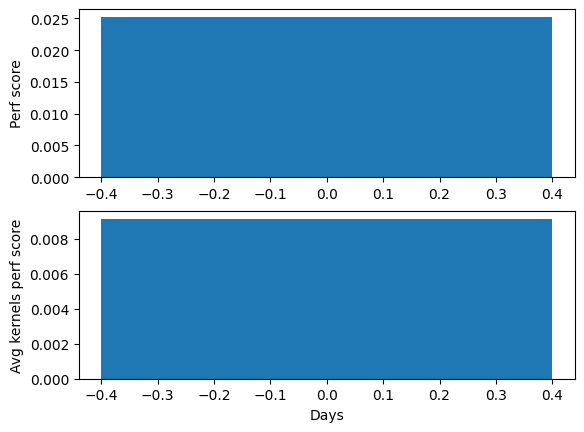

In [151]:
fig, ax = plt.subplots(2)
days_count = len(train_stats)
ax[0].bar(list(range(days_count)), [ts.perceive_success_rate for ts in train_stats])
ax[0].set_ylabel('Perf score')

ax[1].bar(list(range(days_count)), [ts.kernels_match_success_rates.mean for ts in train_stats])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Avg kernels perf score')
plt.show()

In [150]:
assert len(test_images) > 0

grid.reset_stats()

for image in tqdm(test_images):
    grid.perceive(image, config.kernel_match_threshold, config.kernel_grid_match_threshold)

  0%|          | 0/2500 [00:00<?, ?it/s]


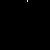
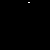
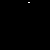
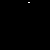
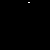
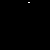
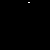
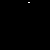
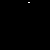
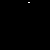
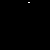
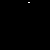
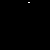
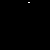
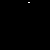
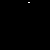
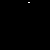
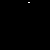
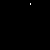
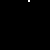
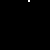
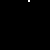
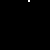
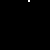
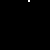
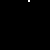
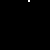
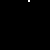
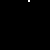
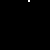
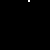
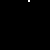
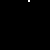
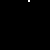
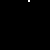
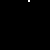
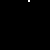
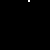
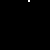
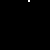
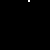
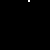
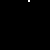
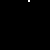
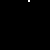
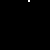
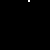
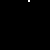
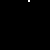
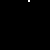
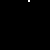
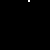
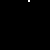
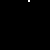
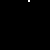
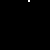
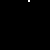
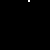
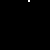
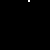
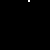
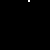
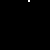
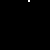
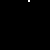
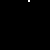
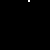
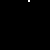
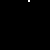
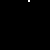
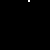
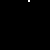
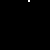
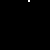
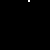
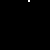
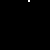
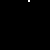
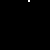
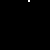
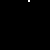
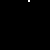
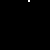
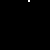
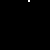
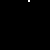
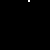
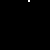
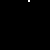
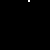
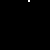
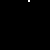
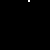
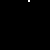
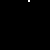
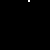
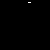
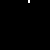
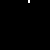
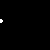
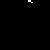
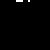
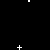
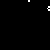
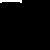
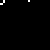
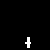
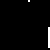
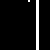
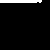
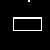
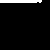
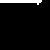
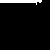
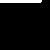
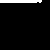
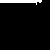
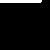
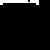
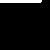
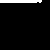
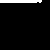
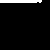
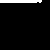
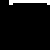
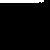
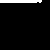
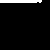
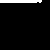
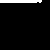
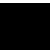
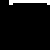
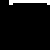
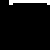
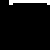
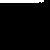
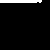
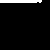
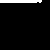
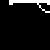
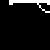
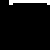
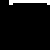
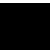
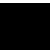
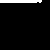
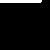
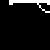
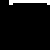
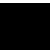
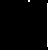
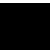
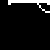
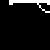
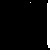
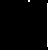
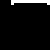
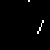
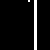
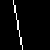
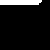
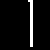
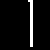
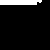
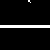
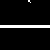
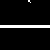
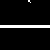
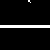
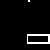
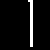
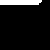
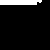
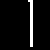
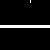
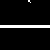
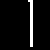
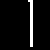
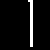
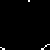
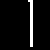
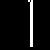
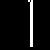
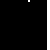
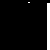
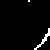
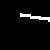
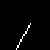
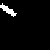
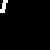
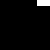
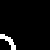
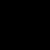
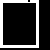
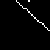
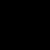
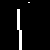
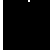
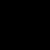
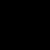
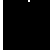
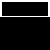
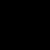
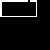
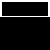
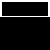
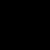
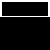
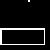
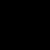
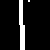
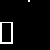
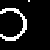
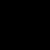
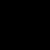
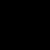
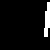
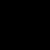
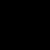
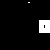
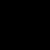
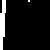
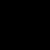
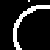
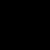
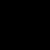
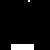
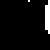
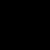
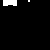
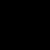
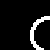
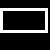
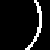
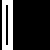
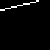
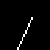
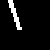
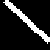
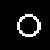
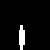
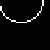
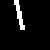
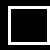
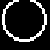
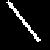
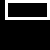
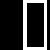
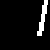
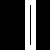
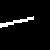
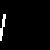
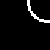
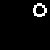
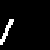
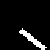

In [152]:
grid.reset_stats()
_, test_images = train_test_split(images, shuffle=True)

for image in tqdm(test_images):
    grid.perceive(image, config.kernel_match_threshold, config.kernel_grid_match_threshold)

kernel_images = grid.get_kernel_images(1)
kernel_images.sort(key=lambda ki: ki.kernel.get_stats().match_success_rate, reverse=True)
_images = []
_captions = {}

for ki in kernel_images:
    _image = ki.image.resize((50, 50))
    _images.append(_image)
    _captions[id(_image)] = f'{ki.kernel.get_stats().match_success_rate * 100:.2f}%'

display_images_grid(_images, grid.size, captions=_captions)